# Finding blobs in 64x64 images using conv2d

In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
from PIL import Image
import random

# Get data

Data reading function

In [42]:
def read_tiff(path, n_images):
    """
    path - Path to the multipage-tiff file
    n_images - Number of pages in the tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(n_images):
        try:
            img.seek(i)
            slice_ = np.zeros((img.height, img.width))
            for j in range(slice_.shape[0]):
                for k in range(slice_.shape[1]):
                    slice_[j,k] = img.getpixel((j, k))

            images.append(slice_)

        except EOFError:
            # Not enough frames in img
            break

    return np.array(images)

Read in blobs tiff

In [43]:
all_dataA=read_tiff('CountBlobs.tif',10000)
all_dataB=read_tiff('CountBlobsB.tif',10000)
all_dataC=read_tiff('CountBlobsC.tif',10000)

In [44]:
dfA=pd.read_csv('CountBlobsTruth.csv')
dfB=pd.read_csv('CountBlobsTruthB.csv')
dfC=pd.read_csv('CountBlobsTruthC.csv')

Read in truth table

# Design network

Define a function to create a convolutional layer, including conv, relu, maxpool, that can be called multiple times

In [74]:
def create_new_conv_layer(input_data, num_input_channels, num_filters, filter_shape, pool_shape, name):
    # setup the filter input shape for tf.nn.conv_2d
    conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels,
                      num_filters]

    # initialise weights and bias for the filter
    weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03),
                                      name=name+'_W')
    bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')

    # setup the convolutional layer operation
    #out_layer = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')
    out_layer=tf.contrib.layers.conv2d(input_data, num_filters, filter_shape)

    # add the bias
    #out_layer += bias

    # apply a ReLU non-linear activation
    #out_layer = tf.nn.relu(out_layer)

    # now perform max pooling
    ksize = [1, pool_shape[0], pool_shape[1], 1]
    strides = [1, 2, 2, 1]
    out_layer = tf.nn.max_pool(out_layer, ksize=ksize, strides=strides, 
                               padding='SAME')

    return out_layer

In [83]:
x=tf.placeholder(dtype=tf.float32, shape=[None, 64,64])
y=tf.placeholder(dtype=tf.float32, shape=[None, 1])

x_shaped=tf.reshape(x, [-1, 64,64,1])
conv1layer=create_new_conv_layer(x_shaped, 1, 32, [5, 5], [2, 2], name='layer1')
conv2layer=create_new_conv_layer(conv1layer, 32, 64, [5, 5], [2, 2], name='layer2')
conv3layer=create_new_conv_layer(conv2layer, 64, 128, [5, 5], [2, 2], name='layer3')

flattened=tf.reshape(conv3layer, [-1,128*8*8 ])
dense1=tf.contrib.layers.fully_connected(flattened,1024)
dense2=tf.contrib.layers.fully_connected(dense1,128)
dense3=tf.contrib.layers.fully_connected(dense2,16)
logits=tf.contrib.layers.fully_connected(dense3,1)

diff=tf.subtract(logits, y)
LS=tf.multiply(diff,diff)
#Add them together
loss=tf.reduce_mean(LS)
train_op=tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# Training on easy set

In [84]:
all_data=all_dataA

train_data=all_data[0:6000, :,:]
validation_data=all_data[6001:8000, :,:]
test_data=all_data[8001:10000, :,:]

In [85]:
df=dfA

all_truth=df['Blobs'].as_matrix()
all_truth=all_truth.reshape(all_truth.shape[0], 1)
train_truth=all_truth[0:6000, :]
validation_truth=all_truth[6001:8000, :]
test_truth=all_truth[8001:10000, :]

In [86]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(2000):
    idx=np.random.choice(6000, replace=False, size=[100])
    cur_train=train_data[idx,:,:]
    cur_truth=train_truth[idx,:]
    _,results, LN,losses=sess.run([train_op, logits, LS, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%300==0):
        print("Error rate: ", LN.shape)
        print("Real loss: ",losses)

Error rate:  (100, 1)
Real loss:  20.1709
Error rate:  (100, 1)
Real loss:  0.151702
Error rate:  (100, 1)
Real loss:  0.0836622
Error rate:  (100, 1)
Real loss:  0.0364741
Error rate:  (100, 1)
Real loss:  0.0186836
Error rate:  (100, 1)
Real loss:  0.0109636
Error rate:  (100, 1)
Real loss:  0.0147453


In [87]:
results, LN,losses=sess.run([logits, LS, loss], feed_dict={x:validation_data, y:validation_truth})

10
9.91669
8.84033203125


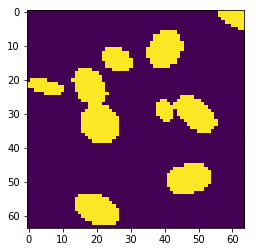

In [88]:
rid=random.randint(0,1999)
plt.imshow(validation_data[rid,:,:])
print(validation_truth[rid,0])
print(results[rid,0])
print(np.mean(validation_data[rid,:,:])/5)

# Training on middle set

In [89]:
all_data=all_dataB

train_data=all_data[0:6000, :,:]
validation_data=all_data[6001:8000, :,:]
test_data=all_data[8001:10000, :,:]

In [90]:
df=dfB

all_truth=df['Blobs'].as_matrix()
all_truth=all_truth.reshape(all_truth.shape[0], 1)
train_truth=all_truth[0:6000, :]
validation_truth=all_truth[6001:8000, :]
test_truth=all_truth[8001:10000, :]

In [108]:

for i in range(2000):
    idx=np.random.choice(6000, replace=False, size=[100])
    cur_train=train_data[idx,:,:]
    cur_truth=train_truth[idx,:]
    _,results, LN,losses=sess.run([train_op, logits, LS, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%300==0):
        print("Error rate: ", LN.shape)
        print("Real loss: ",losses)

Error rate:  (100, 1)
Real loss:  0.179529
Error rate:  (100, 1)
Real loss:  0.139346
Error rate:  (100, 1)
Real loss:  0.113846
Error rate:  (100, 1)
Real loss:  0.0416022
Error rate:  (100, 1)
Real loss:  0.0705337
Error rate:  (100, 1)
Real loss:  0.0233377
Error rate:  (100, 1)
Real loss:  0.0412272


In [109]:
results, LN,losses=sess.run([logits, LS, loss], feed_dict={x:validation_data, y:validation_truth})

3
3.3775
22.9005859375


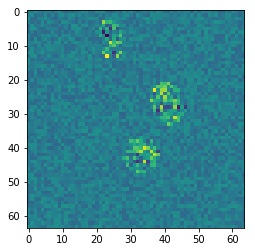

In [155]:
rid=random.randint(0,1999)
plt.imshow(validation_data[rid,:,:])
print(validation_truth[rid,0])
print(results[rid,0])
print(np.mean(validation_data[rid,:,:])/5)

# Training on final set

In [156]:
all_data=all_dataC

train_data=all_data[0:6000, :,:]
validation_data=all_data[6001:8000, :,:]
test_data=all_data[8001:10000, :,:]

In [157]:
df=dfC

all_truth=df['Blobs'].as_matrix()
all_truth=all_truth.reshape(all_truth.shape[0], 1)
train_truth=all_truth[0:6000, :]
validation_truth=all_truth[6001:8000, :]
test_truth=all_truth[8001:10000, :]

In [158]:

for i in range(2000):
    idx=np.random.choice(6000, replace=False, size=[100])
    cur_train=train_data[idx,:,:]
    cur_truth=train_truth[idx,:]
    _,results, LN,losses=sess.run([train_op, logits, LS, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%300==0):
        print("Error rate: ", LN.shape)
        print("Real loss: ",losses)

Error rate:  (100, 1)
Real loss:  43.493
Error rate:  (100, 1)
Real loss:  4.56503
Error rate:  (100, 1)
Real loss:  0.912461
Error rate:  (100, 1)
Real loss:  0.646822
Error rate:  (100, 1)
Real loss:  0.364031
Error rate:  (100, 1)
Real loss:  0.159516
Error rate:  (100, 1)
Real loss:  0.0914002


In [159]:
results, LN,losses=sess.run([logits, LS, loss], feed_dict={x:validation_data, y:validation_truth})
losses

0.48283401

8
7.58809
21.6808105469


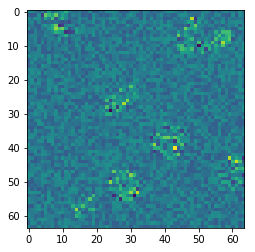

In [224]:
rid=random.randint(0,1999)
plt.imshow(validation_data[rid,:,:])
print(validation_truth[rid,0])
print(results[rid,0])
print(np.mean(validation_data[rid,:,:])/5)

# Compare to simple mean

In [225]:
validation_truth.shape

(1999, 1)

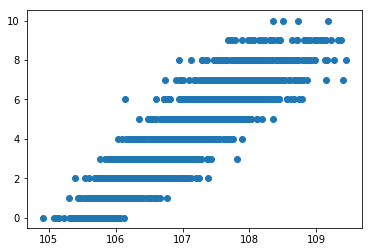

In [226]:
plt.scatter(np.mean(validation_data, axis=(1,2)), validation_truth[:,0])

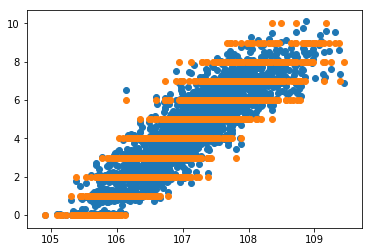

In [227]:
plt.scatter(np.mean(validation_data, axis=(1,2)), results[:,0])
plt.scatter(np.mean(validation_data, axis=(1,2)), validation_truth[:,0])

(array([[  98.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [   2.,  209.,    3.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    9.,  215.,   10.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,   12.,  195.,   20.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,   27.,  192.,   34.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0.,   34.,  214.,   37.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0.,    3.,   46.,  206.,   40.,    0.,
            0.],
        [   0.,    0.,    0.,    0.,    0.,    3.,   56.,  146.,   21.,
            0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    7.,   38.,   69.,
            9.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,   15.,
           28.]]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 array([  0.,   1.,   2.,   3., 

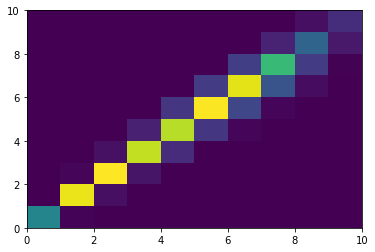

In [232]:
plt.hist2d(validation_truth[:,0], np.round(results[:,0]))